In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

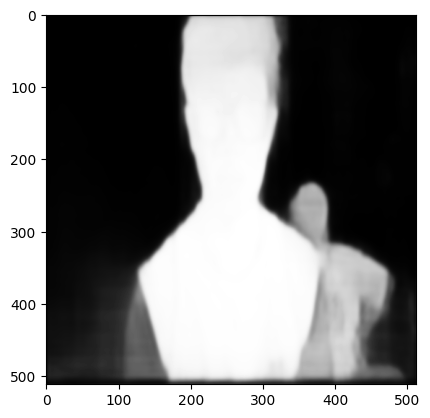

In [59]:
import torch
import segmentation_models_pytorch as smp
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the list to store models
models = []

# Load and append all saved models
eff_model_paths = [
    '/content/drive/MyDrive/masking/eff/best_model_epoch_0.pth',
    '/content/drive/MyDrive/masking/eff/best_model_epoch_1.pth',
    '/content/drive/MyDrive/masking/eff/best_model_epoch_2.pth'
]
res_model_paths = [
    '/content/drive/MyDrive/masking/resnet/best_model_epoch_1.pth',
    '/content/drive/MyDrive/masking/resnet/best_model_epoch_2.pth',
    '/content/drive/MyDrive/masking/resnet/best_model_epoch_4.pth',
    '/content/drive/MyDrive/masking/resnet/best_model_epoch_6.pth',
]

for eff_model_path in eff_model_paths:
    # Initialize the model
    model = smp.Unet(classes=1, encoder_name='efficientnet-b7', encoder_weights='imagenet')
    model = model.to(device)

    # Load the saved weights
    model.load_state_dict(torch.load(eff_model_path, map_location=device))
    model.eval()
    models.append(model)

for res_model_path in res_model_paths:
    # Initialize the model
    model = smp.Unet(classes=1, encoder_name='resnet18', encoder_weights=None)
    model = model.to(device)

    # Load the saved weights
    model.load_state_dict(torch.load(res_model_path, map_location=device))
    model.eval()
    models.append(model)

# Load and preprocess the image
image_path = '/content/drive/MyDrive/masking/2024-03-29-080649.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (512, 512))
image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
image = image.to(device)

# Generate predictions from all models and combine them
with torch.no_grad():
    predictions = []
    for model in models:
        output = model(image)
        predicted_mask = torch.sigmoid(output)
        predictions.append(predicted_mask.cpu().numpy())

# Average the predictions across all models
combined_prediction = np.mean(predictions, axis=0)
# combined_prediction = (combined_prediction > 0.4)

# Plot the final combined prediction
plt.imshow(combined_prediction.squeeze(), cmap='gray')
plt.show()


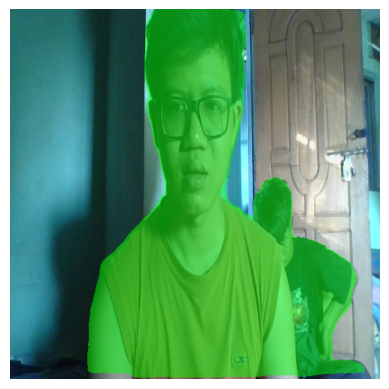

In [60]:
# Load and preprocess the original image
original_image = cv2.imread(image_path)
original_image = cv2.resize(original_image, (512, 512))

# Convert the combined prediction to a binary mask
combined_prediction_binary = (combined_prediction.squeeze() > 0.25).astype(np.uint8)

# Apply the binary mask as an overlay on the original image
overlay = original_image.copy()
overlay[combined_prediction_binary == 1] = [0, 255, 0]  # Green color for the mask

# Apply the overlay with transparency
alpha = 0.5  # Transparency factor
output_image = cv2.addWeighted(overlay, alpha, original_image, 1 - alpha, 0)

# Display the result
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [6]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [8]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [9]:
import torch
import segmentation_models_pytorch as smp
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the list to store models
models = []

# Load and append all saved models
eff_model_paths = [
    '/content/drive/MyDrive/masking/eff/best_model_epoch_0.pth',
    '/content/drive/MyDrive/masking/eff/best_model_epoch_1.pth',
    '/content/drive/MyDrive/masking/eff/best_model_epoch_2.pth'
]
res_model_paths = [
    '/content/drive/MyDrive/masking/resnet/best_model_epoch_1.pth',
    '/content/drive/MyDrive/masking/resnet/best_model_epoch_2.pth',
    '/content/drive/MyDrive/masking/resnet/best_model_epoch_4.pth',
    '/content/drive/MyDrive/masking/resnet/best_model_epoch_6.pth',
]

for eff_model_path in eff_model_paths:
    # Initialize the model
    model = smp.Unet(classes=1, encoder_name='efficientnet-b7', encoder_weights='imagenet')
    model = model.to(device)

    # Load the saved weights
    model.load_state_dict(torch.load(eff_model_path, map_location=device))
    model.eval()
    models.append(model)

for res_model_path in res_model_paths:
    # Initialize the model
    model = smp.Unet(classes=1, encoder_name='resnet18', encoder_weights=None)
    model = model.to(device)

    # Load the saved weights
    model.load_state_dict(torch.load(res_model_path, map_location=device))
    model.eval()
    models.append(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:01<00:00, 180MB/s]


In [58]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
from IPython.display import display, Image

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or use 'XVID'
out = cv2.VideoWriter('/content/drive/MyDrive/masking/output6.mp4', fourcc, 1.55 , (512, 512))
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    image = cv2.resize(frame, (512, 512))
    image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    image = image.to(device)
    # Generate predictions from all models and combine them
    with torch.no_grad():
        predictions = []
        for model in models:
            output = model(image)
            predicted_mask = torch.sigmoid(output)
            predictions.append(predicted_mask.cpu().numpy())

    # Average the predictions across all models
    combined_prediction = np.mean(predictions, axis=0)

    # Convert the combined prediction to a binary mask
    combined_prediction_binary = (combined_prediction.squeeze() > 0.4).astype(np.uint8)

    # Apply the binary mask as an overlay on the original image
    original_image = cv2.resize(frame, (512, 512))  # Use the current frame as the original image
    overlay = original_image.copy()
    overlay[combined_prediction_binary != 1] = [0, 0, 0]  # Green color for the mask

    # Apply the overlay with transparency
    alpha = 1  # Transparency factor
    output_image = cv2.addWeighted(overlay, alpha, original_image, 1 - alpha, 0)
    out.write(output_image)

    # Display the result in real-time
    _, buffer = cv2.imencode('.jpg', output_image)
    output_image = buffer.tobytes()
    display(Image(data=output_image))


    # Check for user input to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.

<IPython.core.display.Javascript object>

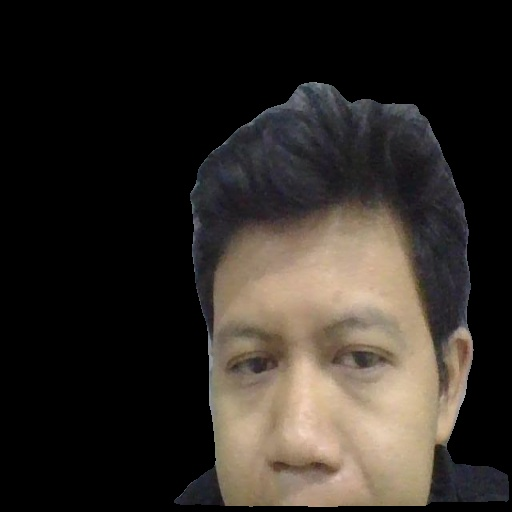

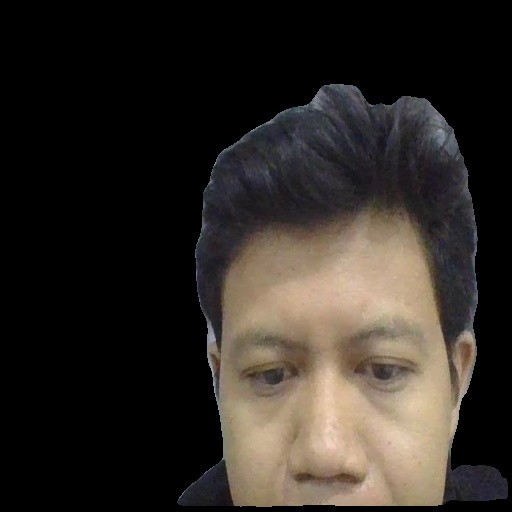

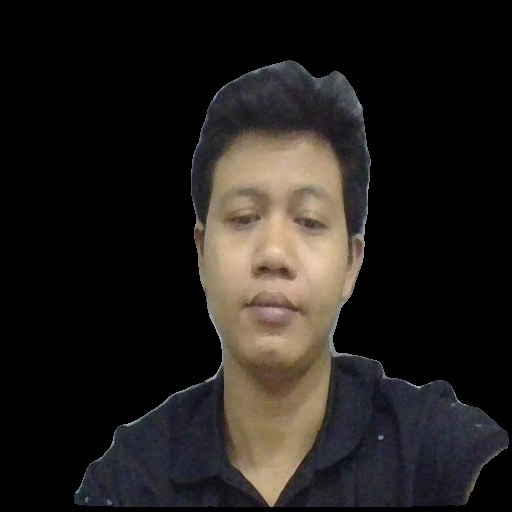

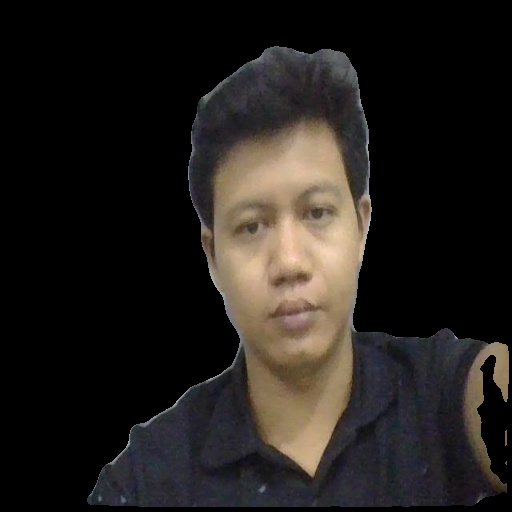

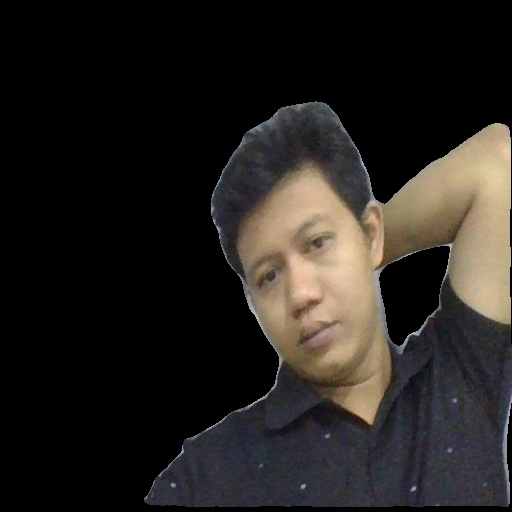

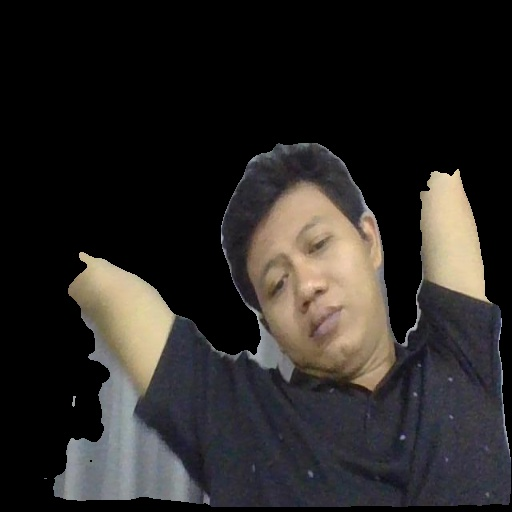

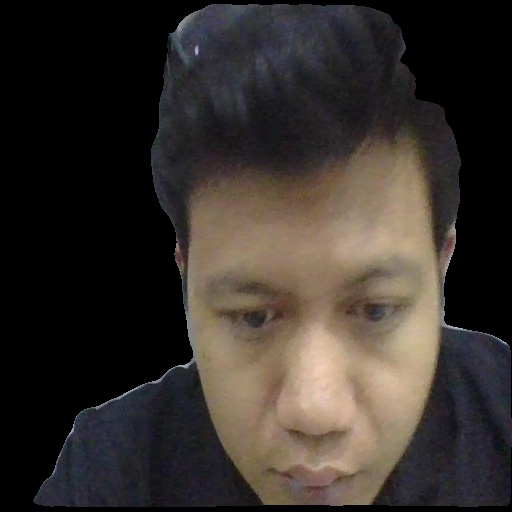

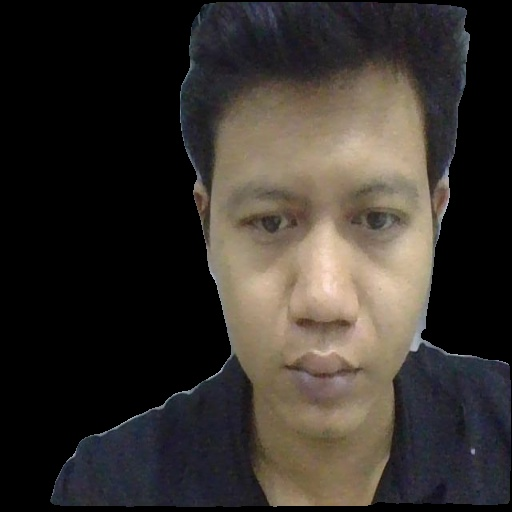

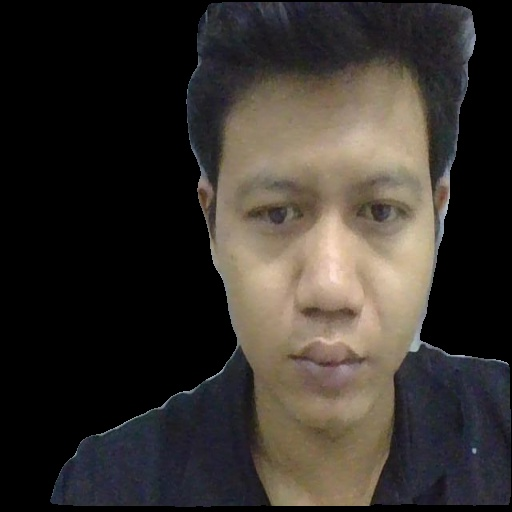

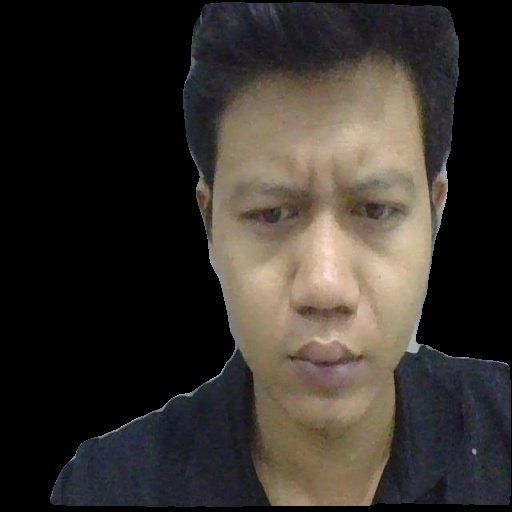

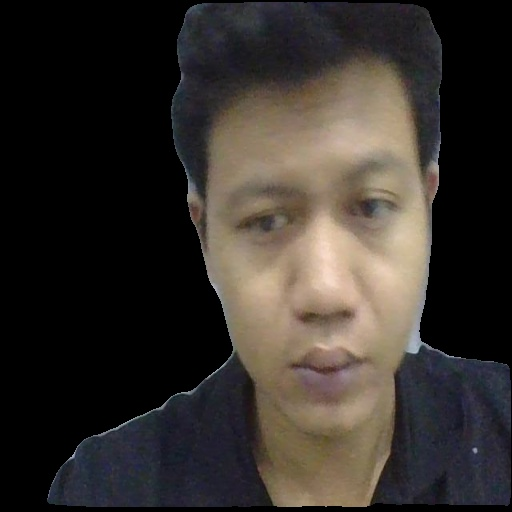

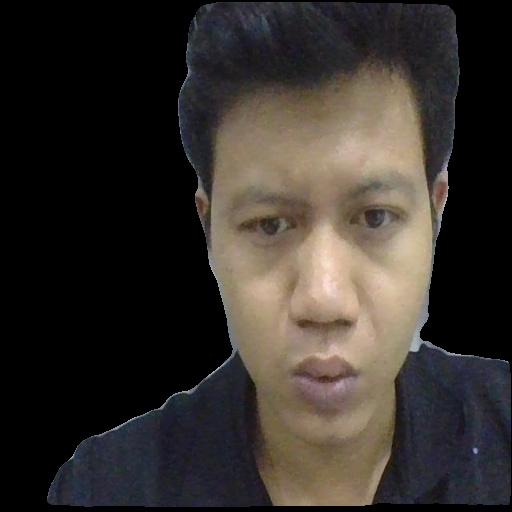

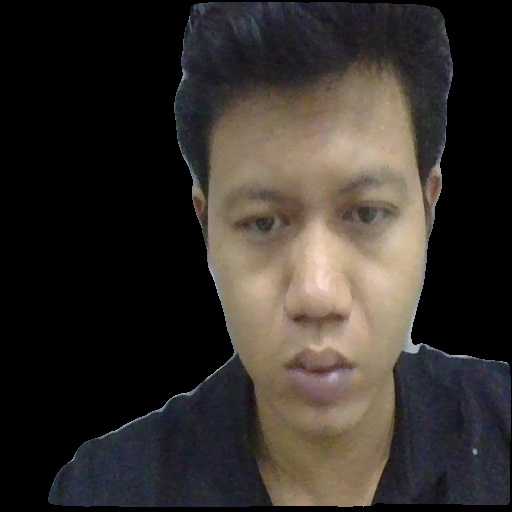

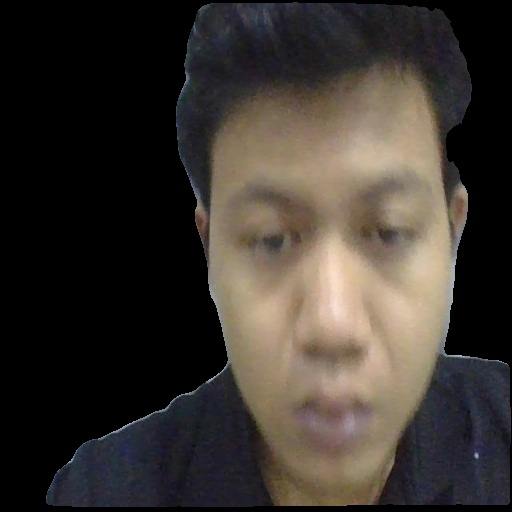

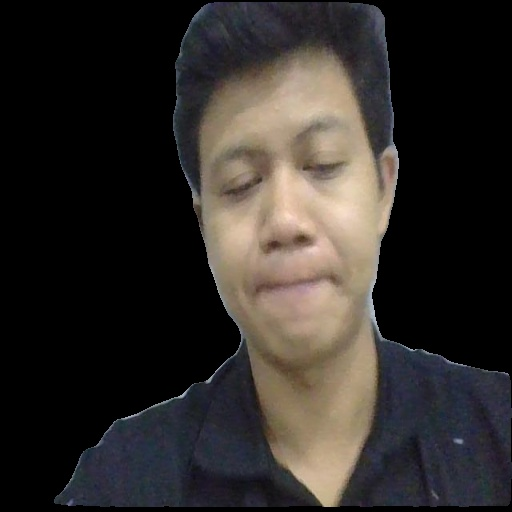

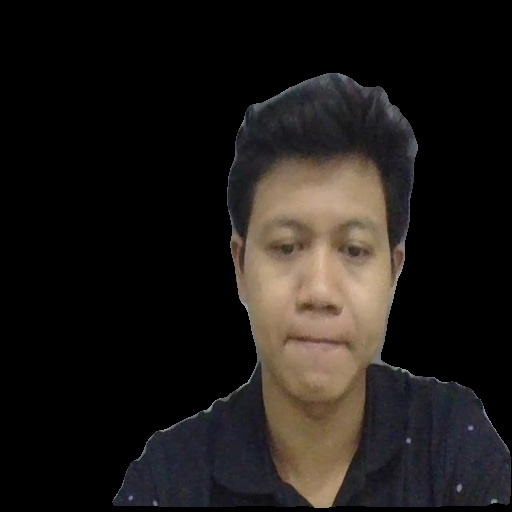

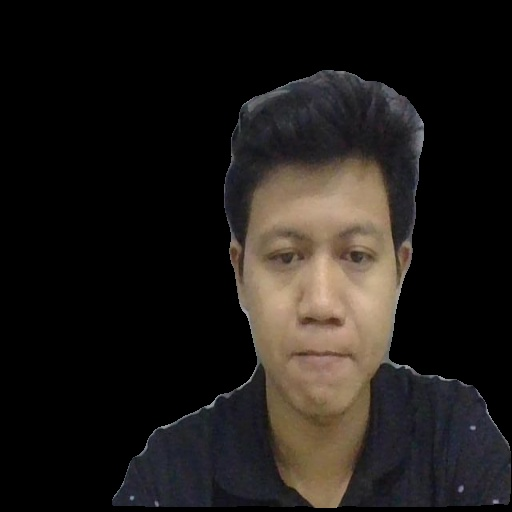

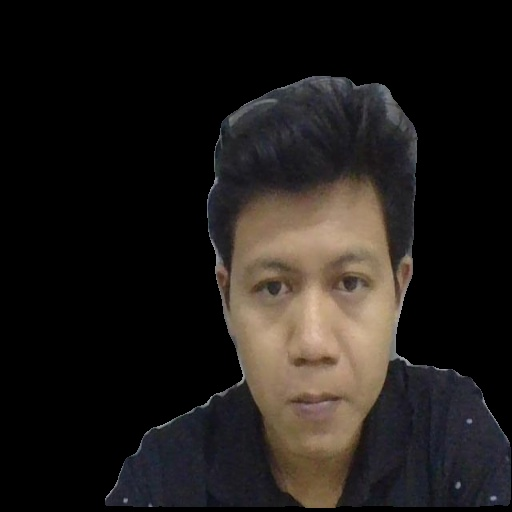

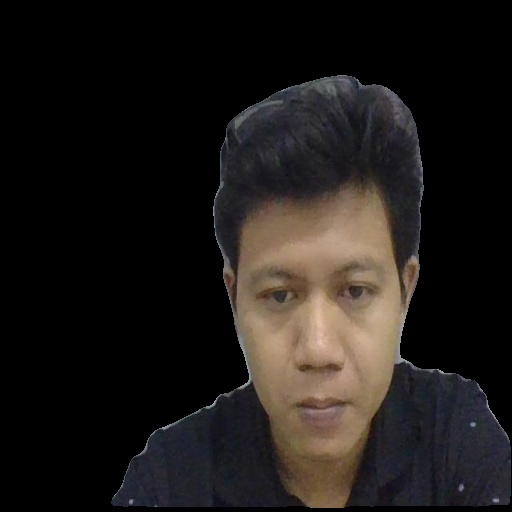

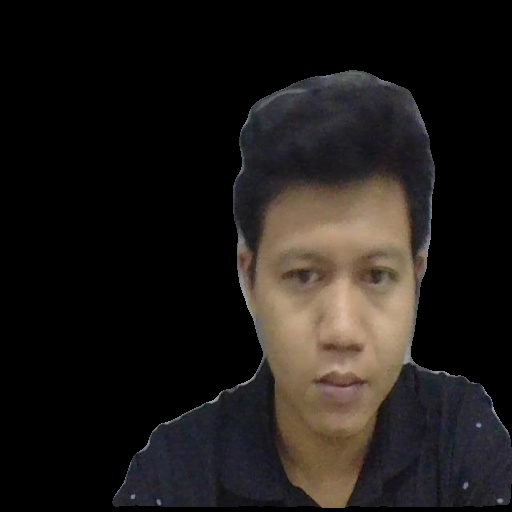

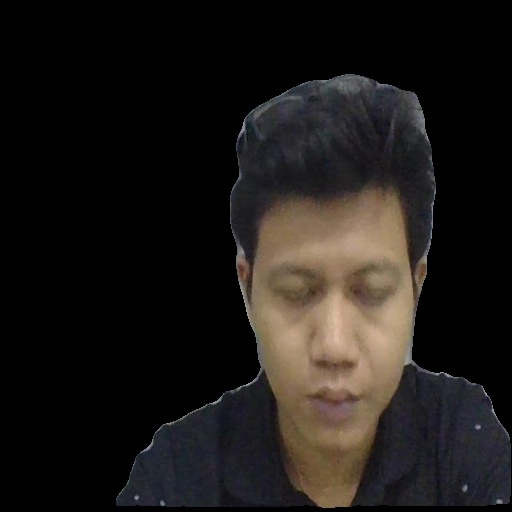

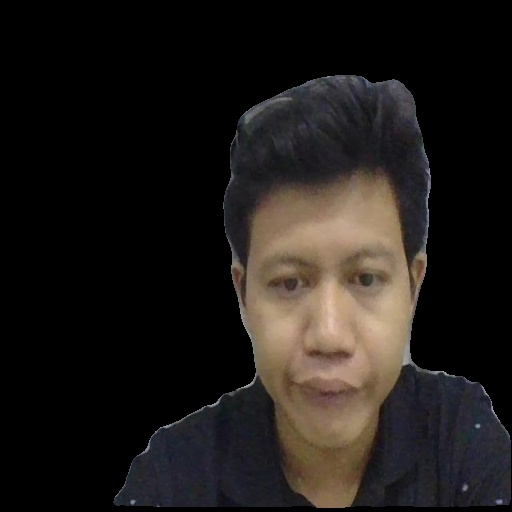

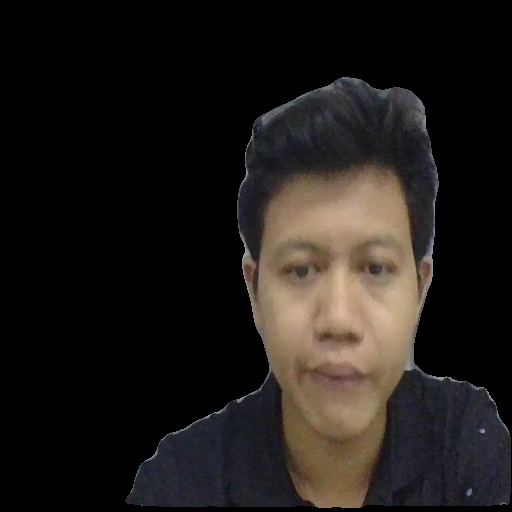

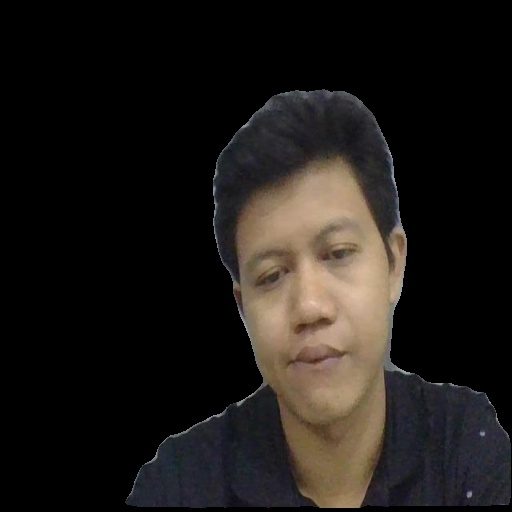

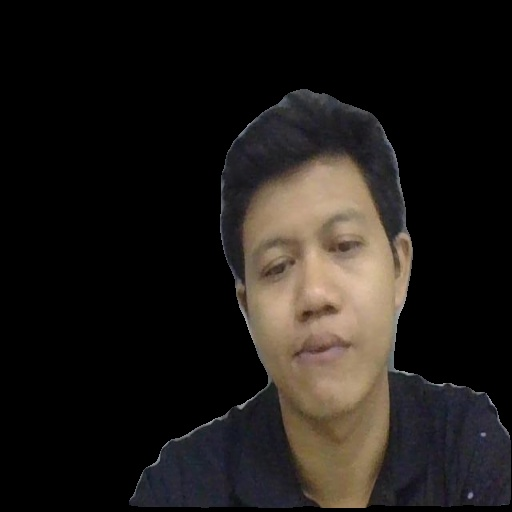

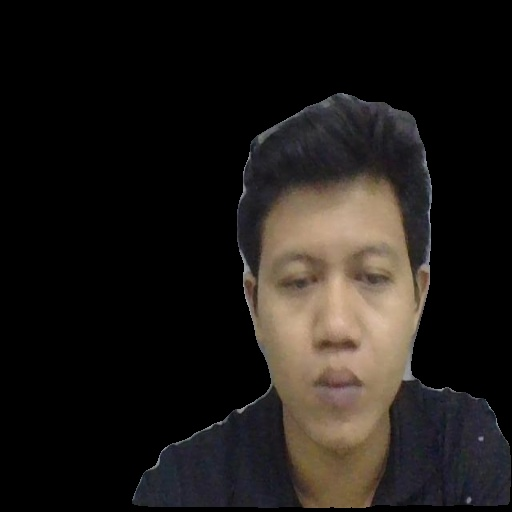

In [57]:
import cv2
import torch
import numpy as np
import time
from IPython.display import display, Image

# Function to pad the image to the nearest shape divisible by 32
def pad_image(image):
    height, width, _ = image.shape
    new_height = int(np.ceil(height / 32) * 32)
    new_width = int(np.ceil(width / 32) * 32)
    padded_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    padded_image[:height, :width] = image
    return padded_image

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or use 'XVID'
out = cv2.VideoWriter('/content/drive/MyDrive/masking/output6.mp4', fourcc, 1.5 , (512, 512))

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    frame = pad_image(frame)  # Pad the input image to the nearest shape divisible by 32

    image = cv2.resize(frame, (512, 512))
    image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    image = image.to(device)

    # Generate predictions from all models and combine them
    with torch.no_grad():
        predictions = []
        for model in models:
            output = model(image)
            predicted_mask = torch.sigmoid(output)
            predictions.append(predicted_mask.cpu().numpy())

    # Average the predictions across all models
    combined_prediction = np.mean(predictions, axis=0)

    # Convert the combined prediction to a binary mask
    combined_prediction_binary = (combined_prediction.squeeze() > 0.4).astype(np.uint8)

    # Apply the binary mask as an overlay on the original image
    original_image = cv2.resize(frame, (512, 512))  # Use the current frame as the original image
    overlay = original_image.copy()
    overlay[combined_prediction_binary != 1] = [0, 0, 0]  # Green color for the mask

    # Apply the overlay with transparency
    alpha = 1  # Transparency factor
    output_image = cv2.addWeighted(overlay, alpha, original_image, 1 - alpha, 0)
    out.write(output_image)

    # Display the result in real-time
    _, buffer = cv2.imencode('.jpg', output_image)
    output_image = buffer.tobytes()
    display(Image(data=output_image))

    # Introduce a delay to ensure real-time processing
    time.sleep(0.1)  # Adjust the delay time as needed

    # Check for user input to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()
